# Neurosymbolic Software Tutorial - Behavior Classification

<a target="_blank" href="https://colab.research.google.com/github/kavigupta/neurosym-lib/blob/main/tutorial/near_demo_behavior_classification.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

_Based on research work by Jennifer J Sun, Megan Tjandrasuwita, Yisong Yue, Ann Kennedy, and others._

## Instruction
- Navigating this notebook on Google Colab: There will be text blocks and code blocks throughout the notebook. The text blocks, such as this one, will contain instructions and questions for you to consider. The code blocks, such as the one below, will contain executable code. Sometimes you will have to modify the code blocks following the instructions in the text blocks. You can run the code block by either pressing control/cmd + enter or by clicking the arrow on left-hand side as shown. `@TODO`
- Saving Work: If you wish to save your work in this .ipynb, we recommend downloading the compressed repository from GitHub, unzipping it, uploading it to Google Drive, and opening this notebook from within Google Drive.


## Outline
- Part 1: Data Exploration
    - We're going to visualize mice trajectories by looking at .
    - **Exercise**: Before reading through the code, look at the trajectory plot and hypothesize what the underlying function might be. Write down what mathematical operators (`sin`, `pow`, `exp`, etc.) would be useful to discover the underlying function.
- Part 2: DSL Generation
    - We're going to formalize our intuition by writing a DSL. Write code for the DSL.
    - **Exercise**: Modify the DSL with the mathematical operators we wrote down earlier. 
- Part 3: Program Generation
    - We're going to use Neural guided search (NEAR) to search for the best-fit program in the DSL.
- Part 4: Program Inspection
    - We will render the program found by NEAR and inspect it's performance. 
    - **Exercise**: Inspect the program found after search. Try different hyperparamters.

## Part 1: Data Exploration
- Cell 1: Define `datagen()` and save data.
- Cell 2: Plot the saved data.
- Cell 3: Exercise

In [1]:
%load_ext autoreload
%autoreload 2
# !cd ../data/ && pip install gdown && gdown 1XPUF4n5iWhQw8v1ujAqDpFefJUVEoT4L && (unzip -o calms21_task1.zip; rm calms21_task1.zip) && cp -r data mice_classification

In [2]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import rc
import numpy as np

# Original mouse trajectory data in x,y coordinates
trajectory_data = np.load("../data/mice_classification/calms21_task1/train_trajectory_data.npy")
print("Trajectory data: " + str(trajectory_data.shape))

# Processed features from trajectory data, consisting of behavior attributes
# such as speed, facing angle, distance between mice, etc.
feature_data = np.load("../data/mice_classification/calms21_task1/train_data.npy")
print("Extracted features: " + str(feature_data.shape))

# Human annotated labels 
labels = np.load("../data/mice_classification/calms21_task1/train_investigation_labels.npy")
print("Label data: " + str(labels.shape))

Trajectory data: (5000, 13, 2, 2, 7)
Extracted features: (5000, 13, 18)
Label data: (5000, 1)


### Exercise

*Observe the scatterplot above. Hypothesize what underlying function would allow us to generate this data. Concretely, write down the mathematical operators (`sin`, `pow`, `exp`, etc.) that would be useful to discover the underlying function.*


<details>
  <summary>Spoiler! Click to see the answer!</summary>
  y is 0 if the point is in the first or second quadrant (where x >= 0), and 1 otherwise. 
</details>


Some useful operators are:
- `mul: (np.array, np.array) -> (np.array)`: Return elementwise multiplication of two arrays of same shape.
- `@TODO`

Processing frame  0


/tmp/ipykernel_155545/3865876030.py:63: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(),


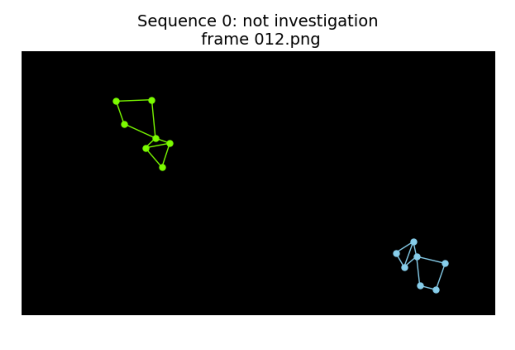

In [3]:
# Plotting utility functions.
 
rc('animation', html='jshtml')
  
#Plotting constants
FRAME_WIDTH_TOP = 1024
FRAME_HEIGHT_TOP = 570
 
RESIDENT_COLOR = 'lawngreen'
INTRUDER_COLOR = 'skyblue'
 
PLOT_MOUSE_START_END = [(0, 1), (0, 2), (1, 3), (2, 3), (3, 4),
                        (3, 5), (4, 6), (5, 6), (1, 2)]
  
def set_figax():
    fig = plt.figure(figsize=(6, 4))
 
    img = np.zeros((FRAME_HEIGHT_TOP, FRAME_WIDTH_TOP, 3))
 
    ax = fig.add_subplot(111)
    ax.imshow(img)
 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
    return fig, ax
 
def plot_mouse(ax, pose, color):
    # Draw each keypoint
    for j in range(7):
        ax.plot(pose[j, 0], pose[j, 1], 'o', color=color, markersize=5)
 
    # Draw a line for each point pair to form the shape of the mouse
 
    for pair in PLOT_MOUSE_START_END:
        line_to_plot = pose[pair, :]
        ax.plot(line_to_plot[:, 0], line_to_plot[
                :, 1], color=color, linewidth=1)
 
def animate_pose_sequence(video_name, keypoint_sequence):
    # Returns the animation of the keypoint sequence between start frame
    # and stop frame. Optionally can display annotations.
    seq = keypoint_sequence.transpose((0,1,3,2))
 
    image_list = []
    
    counter = 0
    for j in range(keypoint_sequence.shape[0]):
        if counter%20 == 0:
          print("Processing frame ", j)
        fig, ax = set_figax()
        plot_mouse(ax, seq[j, 0, :, :], color=RESIDENT_COLOR)
        plot_mouse(ax, seq[j, 1, :, :], color=INTRUDER_COLOR)
         
        ax.set_title(
            video_name + '\n frame {:03d}.png'.format(j), fontsize = 14)
 
        ax.axis('off')
        fig.tight_layout(pad=1)
        ax.margins(0)
 
        fig.canvas.draw()
        image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(),
                                        dtype=np.uint8)
        image_from_plot = image_from_plot.reshape(
            fig.canvas.get_width_height()[::-1] + (3,)) 
 
        image_list.append(image_from_plot)
 
        plt.close()
        counter = counter + 1
 
    # Plot animation.
    fig = plt.figure()
    plt.axis('off')
    im = plt.imshow(image_list[0])
 
    def animate(k):
        im.set_array(image_list[k])
        return im,
    ani = animation.FuncAnimation(fig, animate, frames=len(image_list), blit=True)
    return ani

# Plot the first example of class 0 = not investigation

total_samples = labels.shape[0]

for i in range(total_samples):
  if labels[i] == 0:
    ani = animate_pose_sequence('Sequence ' + str(i) + ': not investigation', trajectory_data[i])
    break
ani

## Part 2: DSL Generation
Given the following observations, we can conjecture that the DSL will contain the following functions:


In [4]:
import torch

import neurosym as ns
from neurosym.examples import near

# # Example usage:
n_classes = 2
dsl = near.simple_crim13_dsl(n_classes)

# # Run a specified program
# model = dsl.compute(dsl.initialize(ns.parse_s_expression("(output (running_avg_last5 (affine_res_angle_head_body)))")))
# print(model(torch.tensor(feature_data[0:200])).shape)
print(dsl.render())

            add :: (#a -> #b, #a -> #b) -> #a -> #b
            mul :: (#a -> #b, #a -> #b) -> #a -> #b
running_avg_last5 :: (#a -> {f, 2}) -> [#a] -> {f, 2}
running_avg_last10 :: (#a -> {f, 2}) -> [#a] -> {f, 2}
running_avg_window5 :: (#a -> {f, 2}) -> [#a] -> {f, 2}
running_avg_window11 :: (#a -> {f, 2}) -> [#a] -> {f, 2}
         output :: ([{f, 18}] -> {f, 2}) -> [{f, 18}] -> {f, 2}
            ite :: (#a -> {f, 1}, #a -> #b, #a -> #b) -> #a -> #b
affine_res_angle_head_body[lin] :: () -> {f, 18} -> {f, 2}
affine_bool_res_angle_head_body[lin] :: () -> {f, 18} -> {f, 1}
affine_axis_ratio[lin] :: () -> {f, 18} -> {f, 2}
affine_bool_axis_ratio[lin] :: () -> {f, 18} -> {f, 1}
affine_speed[lin] :: () -> {f, 18} -> {f, 2}
affine_bool_speed[lin] :: () -> {f, 18} -> {f, 1}
affine_acceleration[lin] :: () -> {f, 18} -> {f, 2}
affine_bool_acceleration[lin] :: () -> {f, 18} -> {f, 1}
affine_tangential_velocity[lin] :: () -> {f, 18} -> {f, 2}
affine_bool_tangential_velocity[lin] :: () -> {f, 18}

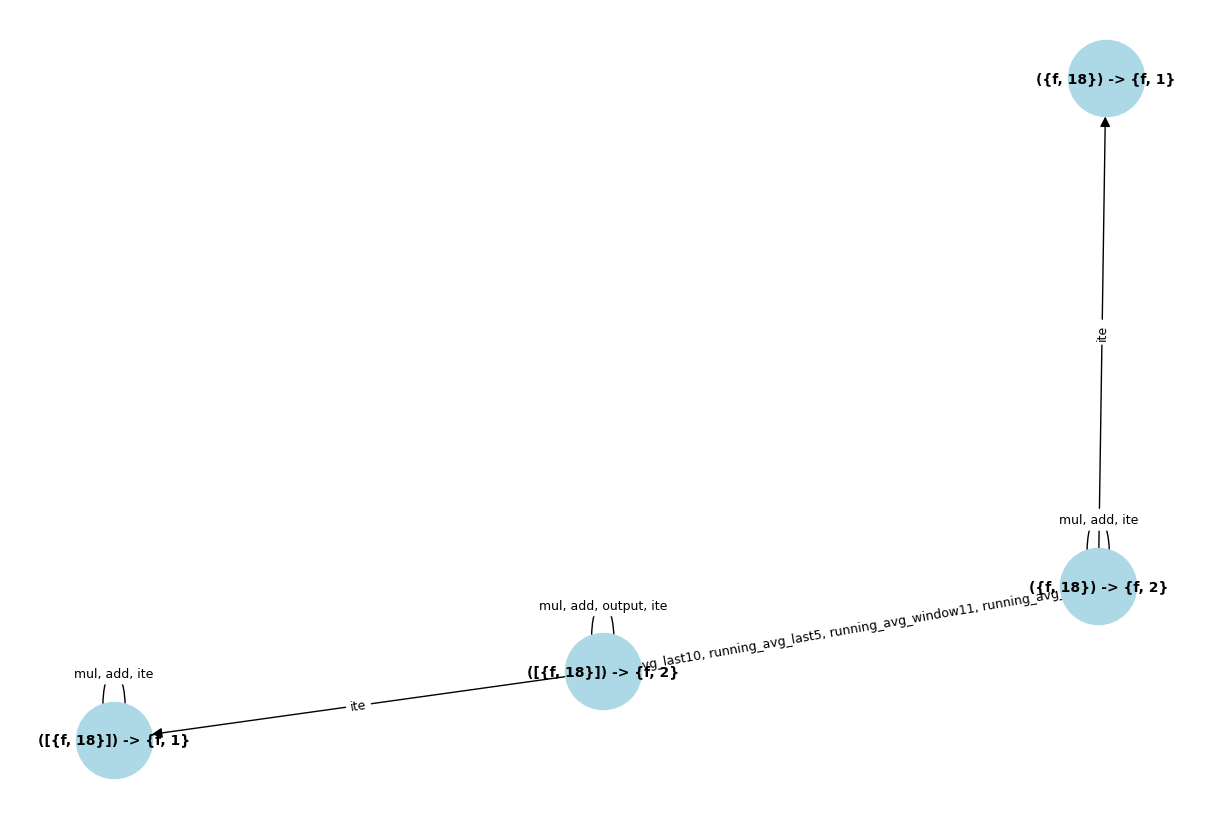

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Set

# temporary helper functions
def render_type(type_instance: ns.Type) -> str:
    if isinstance(type_instance, ns.AtomicType):
        return type_instance.name
    elif isinstance(type_instance, ns.TensorType):
        shape_str = ", ".join(map(str, type_instance.shape))
        return f"{{{render_type(type_instance.dtype)}, {shape_str}}}"
    elif isinstance(type_instance, ns.ListType):
        return f"[{render_type(type_instance.element_type)}]"
    elif isinstance(type_instance, ns.ArrowType):
        inputs = ", ".join(render_type(t) for t in type_instance.input_type)
        output = render_type(type_instance.output_type)
        return f"({inputs}) -> {output}"
    elif isinstance(type_instance, ns.TypeVariable):
        return f"#{type_instance.name}"
    elif isinstance(type_instance, ns.FilteredTypeVariable):
        return f"%{type_instance.name}"
    else:
        raise ValueError(f"Unsupported Type: {type_instance}")


def all_reachable_rules(dsl: ns.DSL):
    if dsl.valid_root_types is None:
        raise ValueError("DSL must have valid root types defined.")
    
    root_types = [
        ns.TypeWithEnvironment(
            typ,
            ns.PermissiveEnvironmment()
        )
        for typ in dsl.valid_root_types
    ]
    
    dag = defaultdict(list)
    visited: Set[ns.TypeWithEnvironment] = set()

    max_depth = 1
    depth = dict()
    queue = root_types[:]
    depth[root_types[0]] = 0
    while queue:
        current_type = queue.pop(0)
        if current_type in visited or depth[current_type] > max_depth:
            continue
        visited.add(current_type)

        for production, arg_types in dsl.productions_for_type(current_type):
            dag[current_type.typ].append((production.symbol(), [arg.typ for arg in arg_types]))
            for arg_type in arg_types:
                if arg_type not in visited:
                    queue.append(arg_type)
                    depth[arg_type] = depth[current_type] + 1
    
    return dict(dag)

def render_dag(dag):
    G = nx.DiGraph()
    edge_labels = defaultdict(list)
    for source_type, edges in dag.items():
        for symbol, target_types in edges:
            for target_type in target_types:
                G.add_edge(render_type(source_type), render_type(target_type))
                edge_labels[(render_type(source_type), render_type(target_type))].append(symbol)

    combined_edge_labels = { edge: ", ".join(list(set(labels))) for edge, labels in edge_labels.items() }

    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", arrowsize=15)
    edge_labels = nx.get_edge_attributes(G, "label")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=combined_edge_labels, font_size=9)
    plt.show()

dag = all_reachable_rules(dsl)
render_dag(dag)


A couple of things to note:
- _Type Definitions and Tags_: The DSL uses types (e.g., `$fL` for tensors of length `L`) and tags (`#a`, `#b`, `#c`) for type safety.
- _Concrete vs. Parameterized Functions_: The DSL offers fixed-behavior functions (add, mul, etc.) and parametrized ones (linear, output) for flexibility. Any composition of these functions is also differentiable.
 - _Pruning_: The DSL can be pruned with prune_to to restrict to specific function types, optimizing for certain operations.
 
 ### Exercise
*Augment the DSL above with the operators you wrote down earlier.*

## Part 3: Program Generation

[Admissible heuristics](https://en.wikipedia.org/wiki/Admissible_heuristic) are heuristics that never overestimate the cost of reaching a goal. These heuristics can be used as part of an informed search algorithm, such as [A* search](https://en.wikipedia.org/wiki/A*_search_algorithm). Here, we use the assumption that sufficiently large neural networks have greater representational power compared to neurosymbolic models or symbolic models, and use this neural relaxation as an admissible heuristic over the program graph search space.

![img](https://github.com/neurosymbolic-learning/Neurosymbolic_Tutorial/blob/popl23/imgs/admissible.png?raw=true)


Operationally, we will synthesize our program top-down and fill holes with a neural network. To do this, we must first define an extension to our DSL that allows us to specify how to fill holes in our program. We will add the following neural functions to our DSL:

* `MLP(X) -> Y`: A multi-layer perceptron (MLP) that takes in `X` and outputs `Y`.
* `RNN(List[X]) -> List[Y]`: A recurrent neural network (RNN) that takes in a list of `X` and outputs a classification `Y`. This is equvalent to a seq2seq RNN with a single output.

Notice that we add type signatures to each partial program. This ensures that we use a type-appropriate neural network to fill each hole.


- Cell 1: Define a pytorch dataset from the saved data.
- Cell 2: Define `neural_dsl`. This DSL extend the DSL we created with _neural modules_.
- Cell 3: Define optimization functions to train module parameters.
- Cell 4: Define a stopping condition for the search.
- Cell 5: Define the search space and initiate the search.

In [6]:
def dataset_factory(train_seed):
    return ns.DatasetWrapper(
        ns.DatasetFromNpy(
            "../data/mice_classification/calms21_task1/train_data.npy",
            "../data/mice_classification/calms21_task1/train_investigation_labels.npy",
            train_seed,
        ),
        ns.DatasetFromNpy(
            "../data/mice_classification/calms21_task1/test_data.npy",
            "../data/mice_classification/calms21_task1/test_investigation_labels.npy",
            None,
        ),
        batch_size=200,
    )


datamodule = dataset_factory(42)
input_dim, output_dim = datamodule.train.get_io_dims()
print(input_dim, output_dim)

18 2


In [7]:
t = ns.TypeDefiner(L=input_dim, O=output_dim)
t.typedef("fL", "{f, $L}")
t.typedef("fO", "{f, $O}")
neural_dsl = near.NeuralDSL.from_dsl(
    dsl=dsl,
    neural_hole_filler=near.GenericMLPRNNNeuralHoleFiller(hidden_size=10),
)

## NEAR with A* Search

We can use NEAR as a heuristic to guide A* search. We maintain a frontier of nodes (starting with an empty program), and at each iteration we choose a node on the frontier to explore by using the NEAR heuristic with a structural cost to estimate its path cost. The search terminates when the frontier is empty, after which we return the best complete program found during our search.

In the code below, we define three functions:

* `classification_cross_entropy_loss` measures the fitness of a program on the validation dataset. This will serve as a way to score partial programs during search.
* `near.near_graph`: This function instantiates the search graph over the space of programs we want to search over.
* `ns.search.bounded_astar`: This function implements a bounded version of the A* algorithm.

Note that each of these functions is independent of the dataset, the DSL, and other functions. This modularity allows us to easily reuse and redefine our synthesis pipeline for different datasets, DSLs, and functions.

In [14]:
pl = ns.import_pytorch_lightning()


def classification_cross_entropy_loss(
    predictions: torch.Tensor, targets: torch.Tensor
) -> torch.Tensor:
    """
    predictions: (B, T, O)
    targets: (B, T, 1)
    """
    targets = targets.squeeze(-1)  # (B, T, 1) -> (B, T)
    predictions = predictions.view(-1, predictions.shape[-1])
    targets = targets.view(-1)
    return torch.nn.functional.cross_entropy(predictions, targets)


trainer_cfg = near.NEARTrainerConfig(
    lr=3e-2,
    n_epochs=20,
    loss_callback=classification_cross_entropy_loss,
    accelerator="cuda:0",
)

validation_cost = near.ValidationCost(
    trainer_cfg=trainer_cfg,
    neural_dsl=neural_dsl,
    datamodule=datamodule,
    structural_cost_weight=0.15, # Larger programs are fine.
)

In [15]:
max_depth = 8
g = near.near_graph(
    neural_dsl,
    neural_dsl.valid_root_types[0],
    is_goal=lambda _: True,
    max_depth=max_depth,
    cost=validation_cost,
)

iterator = ns.search.bounded_astar(g, max_depth=max_depth)
best_program = None
try:
    program = next(iterator)
    cost = validation_cost(program)
    best_program = (program, cost)
except StopIteration:
    pass
print("DONE")

Training ??::<[{f, 18}] -> {f, 2}>
Validation loss: 0.25160833199818927
Training (add ??::<[{f, 18}] -> {f, 2}> ??::<[{f, 18}] -> {f, 2}>)
Validation loss: 0.24921917617321016
Training (mul ??::<[{f, 18}] -> {f, 2}> ??::<[{f, 18}] -> {f, 2}>)
Validation loss: 0.23570796648661296
Training (running_avg_last5 ??::<{f, 18} -> {f, 2}>)
Validation loss: nan
Training (running_avg_last10 ??::<{f, 18} -> {f, 2}>)
Validation loss: nan
Training (running_avg_window5 ??::<{f, 18} -> {f, 2}>)
Validation loss: 0.36659409403800963
Training (running_avg_window11 ??::<{f, 18} -> {f, 2}>)
Validation loss: 0.301761586467425
Training (output ??::<[{f, 18}] -> {f, 2}>)
Validation loss: 0.4194475054740906
Training (ite ??::<[{f, 18}] -> {f, 1}> ??::<[{f, 18}] -> {f, 2}> ??::<[{f, 18}] -> {f, 2}>)
Validation loss: 0.2480740427970886
Training (running_avg_window5 (add ??::<{f, 18} -> {f, 2}> ??::<{f, 18} -> {f, 2}>))
Validation loss: 0.3703937530517578
Training (running_avg_window5 (mul ??::<{f, 18} -> {f, 2}>

## Part 4: Program Inspection

A key benefit of program synthesis is that the output program is interpretable.

- Cell 1: Render the best program.
- Cell 2: Visualize the output space of the best program.
    - Exercise: Does the program discovered line up with your initial hypotheses?

(running_avg_window5 (affine_min_res_nose_dist))


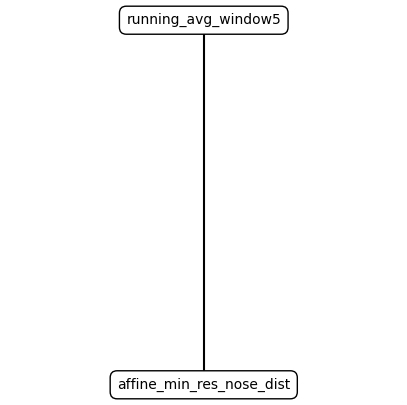

In [16]:
def plot_expression(sexpr, x=0.5, y=1, level=1, dx=0.1, ax=None, text_offset=0.02):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_axis_off()

    ax.text(
        x,
        y,
        sexpr.symbol,
        ha="center",
        va="center",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
    )

    num_children = len(sexpr.children)
    if num_children > 0:
        child_y = y - 1 / level
        for i, child in enumerate(sexpr.children):
            child_x = x - (dx * (num_children - 1) / 2) + i * dx
            ax.plot([x, child_x], [y - text_offset, child_y + text_offset], "k-")
            plot_expression(
                child,
                x=child_x,
                y=child_y,
                level=level + 1,
                dx=dx / 2,
                ax=ax,
                text_offset=text_offset,
            )

    if ax is None:
        plt.show()


print(ns.render_s_expression(best_program[0]))
plot_expression(best_program[0])

In [17]:
from sklearn.metrics import classification_report
module, loss = validation_cost.validate_model(best_program[0], n_epochs=20)
predictions = module(torch.tensor(feature_data), environment=()).argmax(-1).numpy()
report = classification_report(labels, predictions, target_names=["not investigation", "investigation"], output_dict=True)
print(report)


{'not investigation': {'precision': 0.8843076923076924, 'recall': 0.8057190916736754, 'f1-score': 0.8431861522663928, 'support': 3567.0}, 'investigation': {'precision': 0.604, 'recall': 0.7376133984647593, 'f1-score': 0.6641533144831919, 'support': 1433.0}, 'accuracy': 0.7862, 'macro avg': {'precision': 0.7441538461538462, 'recall': 0.7716662450692173, 'f1-score': 0.7536697333747924, 'support': 5000.0}, 'weighted avg': {'precision': 0.8039715076923077, 'recall': 0.7862, 'f1-score': 0.7918753409577275, 'support': 5000.0}}


In [ ]:

report = classification_report(labels, predictions, target_names=["not investigation", "investigation"], output_dict=True)

report['not investigation']['f1-score']
0.8448401693183477

0.8448401693183477